# Analysis of empirical AEA data set from Peter *et al.* 2016 

See https://github.com/NovembreLab/eems-around-the-world/blob/master/ for more information (data set from Fig 1). It has about ~4,700 individuals, the goal is to see if the Madagascar population can be connected with a long range edge (i.e., does it show high residual with default `feems` fit?)

### Imports

In [57]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats
from feems.helper_funcs import cov_to_dist, comp_genetic_vs_fitted_distance

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data wrangling to get `.coord` file

The coordinates are in the `.pop_geo` file and the population order is in the `.pop_order` file. The individual meta-data is in the `.indiv_meta` file (sampleID, popID, which study, etc.) -- need to put these things together into 1 file. 

In [12]:
data_path = pkg_resources.resource_filename("feems", "data/AEA")

location_data = pd.read_csv("{}/c1global1nfd.pop_geo".format(data_path))
sample_data = pd.read_csv("{}/c1global1nfd.indiv_meta".format(data_path))
order = pd.read_table("{}/c1global1nfd.order".format(data_path), header=None, sep=" ")

meta_data = sample_data.merge(location_data)

a = int(date.today().strftime("%Y%m%d"))
np.random.seed(a)

sd = meta_data['accuracy'] * 0.0000001 + 0.00001 # accuracy * 'sdfactor' + EPS
long_jitter = np.random.normal(meta_data['longitude'], sd)
lat_jitter = np.random.normal(meta_data['latitude'], sd)
long_jitter = ["%2.2f" % i for i in long_jitter]
lat_jitter = ["%2.2f" % i for i in lat_jitter]
temp_data = pd.DataFrame({'longitude':long_jitter,
                            'latitude': lat_jitter})

temp_data.to_csv("~/feems/feems/data/AEA/c1global1nfd-%d.coord"%a, sep=" ", header=False, index=False,
                    columns=('longitude', 'latitude'))

## Reading in the data

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 23.68it/s]


In [21]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

n_samples=4697, n_snps=19954


In [41]:
%%time
# setup graph
coord = np.loadtxt("{}/c1global1nfd-{}.coord".format(data_path,a))  # sample coordinates
# outer = np.loadtxt("{}/c1global1nfd.outer".format(data_path))  # outer coordinates
grid_path = "/Users/vivaswat/feems/feems/data/grid_250.shp" # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=0,
                                             outer=None)

CPU times: user 23.2 s, sys: 65.8 ms, total: 23.3 s
Wall time: 23.4 s


In [44]:
print(coord[:5,:])
print(outer[:5,:])
edges[:5,:]

[[38.5 11.5]
 [38.5 11.5]
 [38.5 11.5]
 [38.5 11.5]
 [38.5 11.5]]
[[ 28.  -32. ]
 [ 21.1 -27.8]
 [ 17.3 -24.3]
 [-13.2   8.5]
 [-16.7  13.4]]


array([[3014, 3015],
       [1687, 1688],
       [1964, 1996],
       [2717, 2728],
       [2928, 2948]])

In [45]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges)

CPU times: user 15min 48s, sys: 48.7 s, total: 16min 36s
Wall time: 16min 48s


In [52]:
projection = ccrs.EquidistantConic(central_longitude=40.0, central_latitude=40.0)

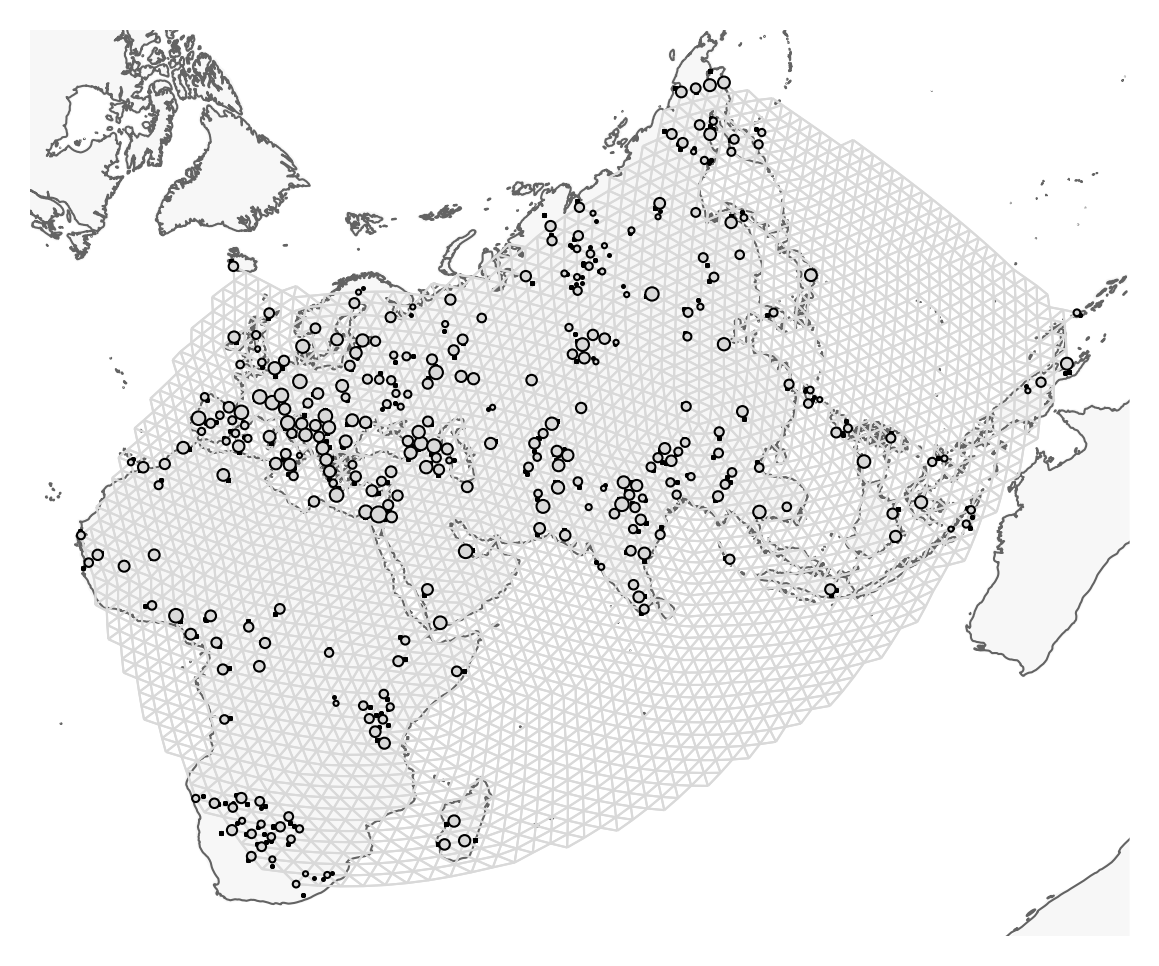

In [55]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, 
        obs_node_size=1.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [58]:
%%time
la = np.logspace(-6, 2, 5)
run_cv(sp_graph, lamb_grid=la)


 fold= 0
iteration lambda=5/5 alpha=1/1
 fold= 1
iteration lambda=5/5 alpha=1/1
 fold= 2
iteration lambda=5/5 alpha=1/1
 fold= 3
iteration lambda=5/5 alpha=1/1
 fold= 4
iteration lambda=5/5 alpha=1/1CPU times: user 31min 19s, sys: 8min 16s, total: 39min 36s
Wall time: 11min 24s


array([[[0.07167798],
        [0.07149425],
        [0.07162937],
        [0.07097158],
        [0.07016691]],

       [[0.08014129],
        [0.07978643],
        [0.07677634],
        [0.06937053],
        [0.07008476]],

       [[0.08486505],
        [0.08007969],
        [0.07593942],
        [0.07601908],
        [0.07619603]],

       [[0.07533011],
        [0.07520713],
        [0.07524911],
        [0.07482386],
        [0.07554521]],

       [[0.07583196],
        [0.0755285 ],
        [0.07548572],
        [0.07530939],
        [0.07535299]]])

In [133]:
%%time
max_res_nodes = comp_genetic_vs_fitted_distance(sp_graph, n_lre=10, lamb=10.0, plotFig=False)

constant-w/variance fit, converged in 134 iterations, train_loss=-1366211.6953424
lambda=10.0000000, alpha=0.3287958, converged in 241 iterations, train_loss=-2011024.1065007
CPU times: user 2min 11s, sys: 27.9 s, total: 2min 39s
Wall time: 49.1 s


In [65]:
# permuted_idx = query_node_attributes(sp_graph, "permuted_idx")
# obs_perm_ids = permuted_idx[: sp_graph.n_observed_nodes]
# max_idx = permuted_idx[np.ravel(max_res_nodes)]
# max_res_nodes = list(zip(max_idx[::2],max_idx[1::2]))

In [134]:
max_res_nodes

[(144, 296),
 (284, 296),
 (223, 267),
 (195, 296),
 (284, 293),
 (274, 296),
 (273, 296),
 (19, 267),
 (272, 296),
 (289, 296)]

In [135]:
np.unique(np.ravel(max_res_nodes))
#array([144, 195, 223, 267, 284, 293, 296])
#"estonians", "off coast of eastern russia", "south central china", "athens", "northwest spain", "west kenya", "malta"

array([ 19, 144, 195, 223, 267, 272, 273, 274, 284, 289, 293, 296])

In [136]:
print(location_data['popId'][np.unique(np.ravel(max_res_nodes))])
print(location_data.iloc[np.unique(np.ravel(max_res_nodes)),1:3])
[sample_data['sampleId'][sample_data['popId']==popid] for popid in location_data['popId'][np.unique(np.ravel(max_res_nodes))]]

19      64
144    262
195    418
223    444
267    501
272    544
273    543
274    546
284    547
289    454
293    340
296    522
Name: popId, dtype: int64
     latitude  longitude
19      39.60      22.20
144     62.56      97.41
195     54.70     164.50
223     28.00     103.00
267     38.00      23.70
272     41.40      -4.50
273     39.90      -4.00
274     39.00      -6.00
284     42.50      -8.10
289     23.70      90.40
293     -0.10      34.30
296     35.90      14.40


[407     EstoniansGreeceThessaly1
 408    EstoniansGreeceThessaly10
 409     EstoniansGreeceThessaly2
 410     EstoniansGreeceThessaly3
 411     EstoniansGreeceThessaly4
 412     EstoniansGreeceThessaly5
 413     EstoniansGreeceThessaly6
 414     EstoniansGreeceThessaly7
 415     EstoniansGreeceThessaly8
 416     EstoniansGreeceThessaly9
 Name: sampleId, dtype: object,
 1966    EstoniansEvk42
 Name: sampleId, dtype: object,
 2463     LAZARIDISAle9
 2464    LAZARIDISAle14
 2465    LAZARIDISAle16
 2466    LAZARIDISAle32
 Name: sampleId, dtype: object,
 2953    LAZARIDISHGDP01179
 2954    LAZARIDISHGDP01180
 2955    LAZARIDISHGDP01181
 2956    LAZARIDISHGDP01182
 2957    LAZARIDISHGDP01183
 2958    LAZARIDISHGDP01184
 2959    LAZARIDISHGDP01185
 2960    LAZARIDISHGDP01186
 2961    LAZARIDISHGDP01187
 2962    LAZARIDISHGDP01188
 Name: sampleId, dtype: object,
 3370    LAZARIDISNA17373
 3371    LAZARIDISNA17374
 3372    LAZARIDISNA17375
 3373    LAZARIDISNA17376
 3374    LAZARIDISNA17377
 3

latitude  longitude
144     62.56      97.41
195     54.70     164.50
223     28.00     103.00
267     38.00      23.70
284     42.50      -8.10
293     -0.10      34.30
296     35.90      14.40